In [2]:
import pandas as pd
import json

# Loading our JSON file into a DataFrame
with open('../data/user-wallet-transactions.json', 'r') as f:
    df = pd.DataFrame(json.load(f))

print(f"Total transactions: {len(df)}")

df.head()


Total transactions: 100000


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [3]:
df_clean = df[['userWallet', 'timestamp', 'action', 'actionData']].copy()

# Converting timestamp to readable datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], unit='s')
df_clean['action'].value_counts()


action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

In [4]:
import numpy as np

# Extracting amount from 'actionData' and converted to numeric
df_clean['amount'] = df_clean['actionData'].apply(lambda x: float(x.get('amount', 0)) if isinstance(x, dict) else 0)

# Created a pivot table: sum of amount per action per wallet
amount_features = df_clean.pivot_table(
    index='userWallet',
    columns='action',
    values='amount',
    aggfunc='sum',
    fill_value=0
).rename(columns={
    'deposit': 'total_deposit',
    'borrow': 'total_borrow',
    'repay': 'total_repay',
    'redeemunderlying': 'total_withdraw',
    'liquidationcall': 'total_liquidation_amount'
})

# Counting each action per wallet
count_features = df_clean.pivot_table(
    index='userWallet',
    columns='action',
    values='timestamp',
    aggfunc='count',
    fill_value=0
).add_prefix('count_')

# First and last transaction per wallet
wallet_times = df_clean.groupby('userWallet')['timestamp'].agg(['min', 'max'])
wallet_times['active_days'] = (wallet_times['max'] - wallet_times['min']).dt.days + 1

# Combine all features
features = pd.concat([amount_features, count_features, wallet_times], axis=1)

# Add derived features
features['repay_ratio'] = features['total_repay'] / (features['total_borrow'] + 1e-6)  # avoid division by 0
features['liquidated'] = features['count_liquidationcall'] > 0
features = features.fillna(0)

features.head()


,total_borrow,total_deposit,total_liquidation_amount,total_withdraw,total_repay,count_borrow,count_deposit,count_liquidationcall,count_redeemunderlying,count_repay,min,max,active_days,repay_ratio,liquidated
userWallet,,,,,,,,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,0.000000e+00,2.000000e+09,0.0,0.000000e+00,0.000000e+00,0,1,0,0,0,2021-08-17 05:29:26,2021-08-17 05:29:26,1,0.000000e+00,False
0x000000000051d07a4fb3bd10121a343d85818da6,0.000000e+00,1.450000e+20,0.0,0.000000e+00,0.000000e+00,0,1,0,0,0,2021-05-20 15:36:53,2021-05-20 15:36:53,1,0.000000e+00,False
0x000000000096026fb41fc39f9875d164bd82e2dc,0.000000e+00,5.000000e+15,0.0,0.000000e+00,0.000000e+00,0,2,0,0,0,2021-07-24 09:28:33,2021-07-31 23:15:18,8,0.000000e+00,False
0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.000000e+00,0.0,4.835297e+18,0.000000e+00,0,0,0,17,0,2021-04-19 15:23:17,2021-08-26 23:15:16,130,0.000000e+00,False
0x0000000002032370b971dabd36d72f3e5a7bf1ee,3.946000e+22,9.459366e+22,0.0,3.946556e+22,7.002457e+10,15,250,0,130,4,2021-04-21 21:28:30,2021-09-01 18:15:24,133,1.774571e-12,False


Wallet counts per cluster:
cluster
0    3223
1     175
3      97
2       2
Name: count, dtype: int64


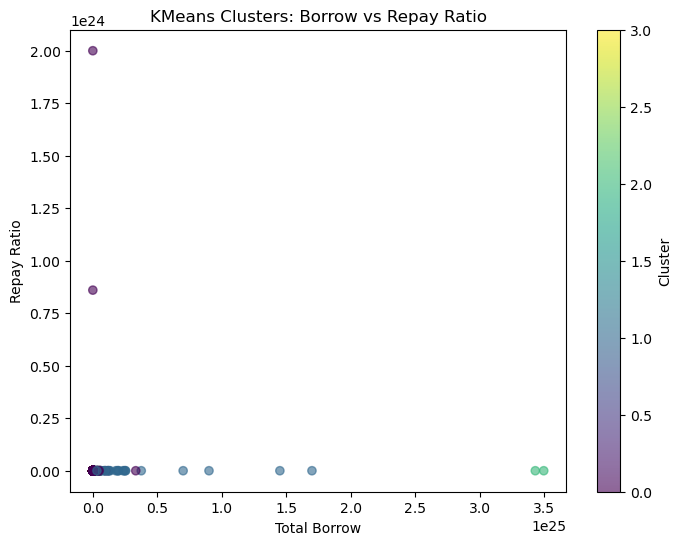

In [6]:
#KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = features.drop(columns=['min', 'max', 'liquidated']).copy()
X['liquidated'] = features['liquidated'].astype(int)

# Fill any NULL values
X = X.fillna(0)

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Addiing cluster labels to the features DataFrame
features['cluster'] = clusters

# Checking cluster counts
print("Wallet counts per cluster:")
print(features['cluster'].value_counts())

# Visualize clusters by total_borrow vs repay_ratio
plt.figure(figsize=(8,6))
plt.scatter(features['total_borrow'], features['repay_ratio'], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Total Borrow')
plt.ylabel('Repay Ratio')
plt.title('KMeans Clusters: Borrow vs Repay Ratio')
plt.colorbar(label='Cluster')
plt.show()


In [7]:
cluster_summary = features.groupby('cluster').mean(numeric_only=True)
cluster_summary


,total_borrow,total_deposit,total_liquidation_amount,total_withdraw,total_repay,count_borrow,count_deposit,count_liquidationcall,count_redeemunderlying,count_repay,active_days,repay_ratio,liquidated
cluster,,,,,,,,,,,,,
0,4.308476e+21,9.772061e+21,0.0,7.742920e+21,2.624105e+21,2.072293,5.431896,0.000000,2.852312,1.326094,17.711759,8.873720e+20,0.000000
1,4.828565e+23,5.142608e+23,0.0,1.689665e+23,1.491140e+23,52.171429,103.640000,0.028571,45.931429,42.445714,91.451429,5.226642e-01,0.028571
2,3.463747e+25,4.683182e+25,0.0,4.681501e+25,3.465953e+25,32.000000,42.500000,0.000000,26.000000,17.000000,14.000000,1.000632e+00,0.000000
3,1.367017e+22,4.948893e+22,0.0,1.327173e+23,6.574301e+21,12.505155,21.432990,2.505155,154.865979,8.422680,60.731959,3.151591e-01,0.989691


<Axes: xlabel='score', ylabel='Count'>

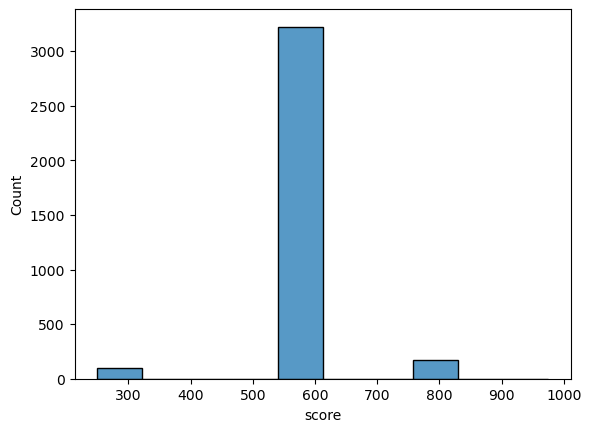

In [17]:
import seaborn as sns

def assign_score(cluster):
    if cluster == 2:
        return 975
    elif cluster == 1:
        return 800
    elif cluster == 3:
        return 250
    else:
        return 550  # cluster 0

features['score'] = features['cluster'].apply(assign_score)

#Visualizing scores
sns.histplot(features['score'], bins=10)


In [21]:
scored_wallets.to_csv('scored_wallets.csv')
#check the "Output" folder for the final output